The code is fully self-contained. 

The only requirement is to run the Data_Preparation_01_v3 code first and to change the directory in which the data from that file are loaded, sections (1, 5, 6, 7, 10)

I think there might be some problems using some libraries in the code with the newest python version. I used 3.10.6 to avoid using any nightly build...


-----------------------------------------------------------

# Réseau Convolutionnel Temporel (TCN) implementation for:
# Volatility Prediction and Optimal Asset Allocation

In this code we want to try to predict the Covariance Matrix between the returns of the 8 sectorial ETFs using a Temporal Convolutional Network (TCN)

We will then use the predicted covariance matrix to build the tangent portfolio (using basic Mathematical Finance techniques), to see if we can actually try to perform better than the market.

The results are promising, but in order for this strategy to be viable we would need to implement some more real world features such as slippage, trading costs...

In [53]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from tqdm.auto import tqdm
import yfinance as yf
import random
import cvxpy as cp
from itertools import product

# 1) DATA PREPARATION and Building of Cholesky Training Set

In [55]:
# Load daily ETF log returns
filepath = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\etf_returns_v4.csv"

# Read Data
df = pd.read_csv(
    filepath,
    index_col=0, parse_dates=True
)
df.dropna(inplace=True)  # Drop remaining NaNs

print("Preview of returns data:")
print(df.head(3))
print("\n\n\n")

# (Optional) Scaling of the returns using MinMax:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# We'll use unscaled data for covariance
data = df  # or df_scaled if desired


# Definition of Window_size and Sequence_length
# I give as input 63 days worth of returns and therefore of Cholesky decompositions to the TCN. Each Cholesky Decomposition is calculated using the previous 21 days worth of returns.
# I also tried with lower/higher numbers to make the model more dynamic/reduce overfitting

##################################################################

# Number of days used to create a covariance matrix
window_size = 21
# Number of matrixes I give in input to the model
sequence_length = 63

##################################################################

# Rolling window size for covariance
cov_matrices = []
dates = []

for i in range(window_size, len(data)):
    window = data.iloc[i - window_size : i]
    cov = window.cov().values
    # Skip if there's any NaN
    if np.isnan(cov).any():
        continue
    cov_matrices.append(cov)
    dates.append(data.index[i])

cov_matrices = np.stack(cov_matrices)  # shape: (samples, n_assets, n_assets)
print("Found", len(cov_matrices), "valid rolling covariance matrices")
print("\n\n\n")

# Cholesky decomposition (with a small stabilizer on the diagonal to avoid dealing with singular matrixes)
cholesky_list = []
for i, cov in enumerate(cov_matrices):
    try:
        L = np.linalg.cholesky(cov + np.eye(cov.shape[0]) * 1e-8)
        cholesky_list.append(L)
    except np.linalg.LinAlgError:
        pass

cholesky_matrices = np.array(cholesky_list)
print("Total valid Cholesky matrices:", len(cholesky_matrices))
print("\n\n\n")

# Build supervised sequences: X = 63 consecutive Cholesky, y = next day Cholesky

X_list, y_list = [], []
for i in range(sequence_length, len(cholesky_matrices)):
    seq_X = cholesky_matrices[i - sequence_length : i]
    seq_y = cholesky_matrices[i]
    X_list.append(seq_X)
    y_list.append(seq_y)

X = np.stack(X_list)  # shape: (samples, seq_len, n_assets, n_assets)
y = np.stack(y_list)  # shape: (samples, n_assets, n_assets)
print("X.shape =", X.shape, "y.shape =", y.shape)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


Preview of returns data:
                 XLE       XLF       XLI       XLK       XLP       XLU  \
Date                                                                     
1999-01-05 -0.005373  0.009291  0.020435  0.025247  0.007512  0.012008   
1999-01-06  0.032464  0.031211  0.021264  0.029120  0.012018  0.010325   
1999-01-07 -0.004573  0.015248 -0.008701 -0.003144 -0.011442 -0.003601   

                 XLV       XLY  
Date                            
1999-01-05  0.015542  0.016707  
1999-01-06  0.016471  0.028006  
1999-01-07 -0.004678 -0.001151  




Found 6579 valid rolling covariance matrices




Total valid Cholesky matrices: 6579




X.shape = (6516, 63, 8, 8) y.shape = (6516, 8, 8)


# 2) DEFINE A DATASET + DATALOADER FOR TRAINING + SETTING SEED

In [56]:
class CholeskyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = CholeskyDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# SETTING A SEED FOR MORE REPRODUCIBILITY

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




# 3) DEFINE THE TCN MODEL ARCHITECTURE

In [57]:
# ===== DEFINE THE TCN MODEL ARCHITECTURE =====

class TemporalBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                 dilation: int,
                 padding: int,
                 activation_cls: type[nn.Module] = nn.ReLU):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      dilation=dilation),
            activation_cls()
        )

    def forward(self, x):
        return self.net(x)


class TCNModel(nn.Module):
    """
    TCN for predicting next-day Cholesky factor with customizable activations.
    """
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 conv_activations: list[type[nn.Module]] = None,
                 linear_activations: list[type[nn.Module]] = None):
        super().__init__()

        # Defaults to [ReLU, ReLU, Tanh] and [ReLU, Identity] if not provided
        if conv_activations is None:
            conv_activations = [nn.ReLU, nn.ReLU, nn.Tanh]
        if linear_activations is None:
            linear_activations = [nn.ReLU, nn.Identity]

        assert len(conv_activations) == 3, "Need 3 conv activations"
        assert len(linear_activations) == 2, "Need 2 linear activations"

        # Build the 3 TCN blocks
        blocks = []
        for i, act_cls in enumerate(conv_activations):
            dilation = 2 ** i
            padding  = dilation
            in_ch    = input_size if i == 0 else hidden_size
            blocks.append(
                TemporalBlock(in_ch, hidden_size,
                              kernel_size=2,
                              stride=1,
                              dilation=dilation,
                              padding=padding,
                              activation_cls=act_cls)
            )
        self.tcn = nn.Sequential(*blocks)

        # Two-layer MLP head
        self.fc1  = nn.Linear(hidden_size, hidden_size // 2)
        self.act1 = linear_activations[0]()
        self.fc2  = nn.Linear(hidden_size // 2, output_size)
        self.act2 = linear_activations[1]()

    def forward(self, x):
        # x: (batch, seq_len, n_assets, n_assets)
        B, seq, n, _ = x.size()
        x = x.view(B, seq, -1).permute(0, 2, 1)   # -> (batch, features, seq_len)
        h = self.tcn(x)[:, :, -1]                 # take last time step

        h = self.fc1(h)
        h = self.act1(h)
        h = self.fc2(h)
        h = self.act2(h)

        return h.view(B, n, n)



# 4) TRAIN THE TCN MODEL

hybrid approach with Walk-Forward Expanding Window and Expanding Window

hyperparameter tuning

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Flexible TCN that takes a list of conv‐layer activations + linear‐head activations ---
class FlexibleTCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 conv_activations: list[type[nn.Module]],
                 linear_activations: list[type[nn.Module]]):
        super().__init__()
        # Build TCN blocks
        layers = []
        for i, act_cls in enumerate(conv_activations):
            dilation = 2 ** i
            padding  = dilation
            in_ch    = input_size if i == 0 else hidden_size
            layers += [
                nn.Conv1d(in_ch, hidden_size, kernel_size=2,
                          dilation=dilation, padding=padding),
                act_cls()
            ]
        self.tcn = nn.Sequential(*layers)

        # Two‐layer MLP head
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            linear_activations[0](),
            nn.Linear(hidden_size // 2, output_size),
            linear_activations[1]()
        )

    def forward(self, x):
        b, seq, n, _ = x.size()
        x = x.view(b, seq, -1).permute(0, 2, 1)  # → (B, features, seq)
        h = self.tcn(x)[:, :, -1]                # last time step
        return self.linear(h).view(b, n, n)

# --- Hybrid train + rolling‐validation (unchanged) ---
def hybrid_train_val(model, optimizer, criterion,
                     X, y, epochs=10, initial_pct=0.05, batch_size=32):
    initial_train = int(initial_pct * len(X))
    step          = max(1, (len(X) - initial_train) // epochs)
    val_window    = step
    best_val = float("inf")

    for epoch in range(1, epochs + 1):
        train_end = min(len(X), initial_train + (epoch - 1) * step)
        train_ds  = TensorDataset(X[:train_end], y[:train_end])
        train_ld  = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

        model.train()
        for xb, yb in train_ld:
            pred = model(xb.to(device))
            loss = criterion(pred, yb.to(device))
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # rolling‐validation
        val_start = train_end
        val_end   = min(len(X), val_start + val_window)
        if val_end > val_start:
            model.eval()
            with torch.no_grad():
                xb = X[val_start:val_end].to(device)
                yb = y[val_start:val_end].to(device)
                val_loss = criterion(model(xb), yb).item()
            best_val = val_loss

    return best_val

# --- Activation map (only ReLU/Tanh) ---
activation_map = {
    "relu": nn.ReLU,
    "tanh": nn.Tanh,
}

# --- Build the 10 conv‐patterns you asked for ---
# 4 patterns length=2:
conv_patterns = [
    ["relu", "relu"],
    ["relu", "tanh"],
    ["tanh", "relu"],
    ["tanh", "tanh"],
]
# 6 patterns length=3 with exactly one “flip”:
#   3 with two ReLU + one Tanh, and 3 with two Tanh + one ReLU
for base, flip in [("relu", "tanh"), ("tanh", "relu")]:
    for i in range(3):
        patt = [base]*3
        patt[i] = flip
        conv_patterns.append(patt)

# --- Linear‐head patterns (unchanged) ---
linear_patterns = [
    ["relu", "linear"],   # Identity = linear
]

# --- Hyperparameter grid ---
param_grid = {
    "hidden_size":    [32, 64],
    "learning_rate":  [5e-4, 3e-4],
    "conv_pattern":   conv_patterns,
    "linear_pattern": linear_patterns,
}

results = []
for hs, lr, conv_pat, lin_pat in product(
        param_grid["hidden_size"],
        param_grid["learning_rate"],
        param_grid["conv_pattern"],
        param_grid["linear_pattern"]
    ):
    conv_acts = [activation_map[a] for a in conv_pat]
    lin_acts = [
        activation_map[a] if a != "linear" else nn.Identity
        for a in lin_pat
    ]

    model = FlexibleTCN(
        input_size   = df.shape[1]*df.shape[1],
        hidden_size  = hs,
        output_size  = df.shape[1]*df.shape[1],
        conv_activations   = conv_acts,
        linear_activations = lin_acts
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    val_loss = hybrid_train_val(
        model, optimizer, criterion,
        X_tensor, y_tensor,
        epochs=10, initial_pct=0.2, batch_size=64
    )

    config = {
        "Hidden Size"       : hs,
        "Learning Rate"     : lr,
        "Conv Activations"  : conv_pat,
        "Linear Activations": lin_pat,
    }
    print(f"{config} → val_loss={val_loss:.6f}")
    results.append((config, val_loss))

# --- Top 3 models ---
sorted_results = sorted(results, key=lambda x: x[1])
print("\n🔝 Top 3 Models:\n")
for rank, (cfg, vl) in enumerate(sorted_results[:3], start=1):
    print(f"Model #{rank}")
    for k, v in cfg.items():
        print(f"  {k:20s}: {v}")
    print(f"  Validation Loss      : {vl:.6f}")
    print("-"*40)


{'Hidden Size': 16, 'Learning Rate': 0.0008, 'Conv Activations': ['relu', 'relu'], 'Linear Activations': ['relu', 'linear']} → val_loss=0.000006


KeyboardInterrupt: 

BEST MODEL

In [61]:
# ===== Setting the Seed =====
set_seed(4120) # 4120 or 100

# ===== MODEL & OPTIMIZER =====
n_assets    = df.shape[1]
input_size  = n_assets * n_assets
hidden_size = 64                       # ← changed
output_size = input_size

# Use the FlexibleTCN so we can specify mixed activations:
model = FlexibleTCN(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    conv_activations=[nn.ReLU, nn.ReLU, nn.Tanh],    # ← [ReLU, ReLU, Tanh]
    linear_activations=[nn.ReLU, nn.Identity]        # ← [ReLU, Linear]
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)  # ← lr = 0.0003
criterion = nn.MSELoss()

# ===== HYPERPARAMETERS IBRIDI =====
epochs             = 20
initial_pct        = 0.2
initial_train_size = int(initial_pct * len(X_tensor))
step               = max(1, (len(X_tensor) - initial_train_size) // epochs)
val_window         = step  # same rolling window for validation

# ===== TRAIN + ROLLING VALIDATION =====
for epoch in range(1, epochs + 1):
    # 1) expanding train set
    train_end    = min(len(X_tensor), initial_train_size + (epoch - 1) * step)
    train_ds     = TensorDataset(X_tensor[:train_end], y_tensor[:train_end])
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)

    model.train()
    total_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        pred   = model(xb)
        loss   = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # 2) rolling validation immediately after the training block
    val_start = train_end
    val_end   = min(len(X_tensor), val_start + val_window)
    if val_end > val_start:
        model.eval()
        X_val = X_tensor[val_start:val_end].to(device)
        y_val = y_tensor[val_start:val_end].to(device)
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()
    else:
        val_loss = float("nan")

    print(
        f"Epoch {epoch:2d} | "
        f"train_samples={train_end:5d} | "
        f"train_loss={avg_train_loss:.6f} | "
        f"val_loss={val_loss:.6f}"
    )


Epoch 1/20:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch  1 | train_samples= 1303 | train_loss=0.006696 | val_loss=0.004089


Epoch 2/20:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch  2 | train_samples= 1563 | train_loss=0.002024 | val_loss=0.000540


Epoch 3/20:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch  3 | train_samples= 1823 | train_loss=0.000151 | val_loss=0.000005


Epoch 4/20:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch  4 | train_samples= 2083 | train_loss=0.000010 | val_loss=0.000014


Epoch 5/20:   0%|          | 0/74 [00:00<?, ?it/s]

Epoch  5 | train_samples= 2343 | train_loss=0.000010 | val_loss=0.000069


Epoch 6/20:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  6 | train_samples= 2603 | train_loss=0.000015 | val_loss=0.000028


Epoch 7/20:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch  7 | train_samples= 2863 | train_loss=0.000019 | val_loss=0.000019


Epoch 8/20:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch  8 | train_samples= 3123 | train_loss=0.000018 | val_loss=0.000008


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch  9 | train_samples= 3383 | train_loss=0.000016 | val_loss=0.000004


Epoch 10/20:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 10 | train_samples= 3643 | train_loss=0.000015 | val_loss=0.000003


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11 | train_samples= 3903 | train_loss=0.000014 | val_loss=0.000006


Epoch 12/20:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 12 | train_samples= 4163 | train_loss=0.000013 | val_loss=0.000004


Epoch 13/20:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 13 | train_samples= 4423 | train_loss=0.000012 | val_loss=0.000005


Epoch 14/20:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 14 | train_samples= 4683 | train_loss=0.000012 | val_loss=0.000006


Epoch 15/20:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 15 | train_samples= 4943 | train_loss=0.000012 | val_loss=0.000004


Epoch 16/20:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 16 | train_samples= 5203 | train_loss=0.000011 | val_loss=0.000046


Epoch 17/20:   0%|          | 0/171 [00:00<?, ?it/s]

Epoch 17 | train_samples= 5463 | train_loss=0.000013 | val_loss=0.000011


Epoch 18/20:   0%|          | 0/179 [00:00<?, ?it/s]

Epoch 18 | train_samples= 5723 | train_loss=0.000013 | val_loss=0.000013


Epoch 19/20:   0%|          | 0/187 [00:00<?, ?it/s]

Epoch 19 | train_samples= 5983 | train_loss=0.000013 | val_loss=0.000007


Epoch 20/20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20 | train_samples= 6243 | train_loss=0.000012 | val_loss=0.000006



# 5) SAVE & RELOAD THE MODEL WEIGHTS

In [62]:
weights_path = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\MODEL\tcn_cholesky_v4_weights.pth"

model_cov = FlexibleTCN(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    conv_activations=[nn.ReLU, nn.ReLU, nn.Tanh],
    linear_activations=[nn.ReLU, nn.Identity]
)
model_cov.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
model_cov.eval()

print("✅ Covariance-forecast TCN reloaded for inference.")


✅ Covariance-forecast TCN reloaded for inference.


# 6) BACKTEST LOOP USING GLOBAL AVERAGE FOR mu_pred

In [63]:
returns_path = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\etf_returns_v4.csv"


returns = pd.read_csv(returns_path, index_col=0, parse_dates=True)
etf_columns = returns.columns.tolist()
returns.replace([np.inf, -np.inf], np.nan, inplace=True)
returns.dropna(inplace=True)
print("✅ Log returns loaded. Shape:", returns.shape)

def predict_next_day_cov(model_cov, i, returns_df, seq_len): #seq_len=63
    """
    Predict next-day covariance factor from the last 'seq_len' Cholesky matrices,
    which are built from rolling 63-day windows each.
    """
    cov_input = []
    for j in range(i - seq_len, i):
        window = returns_df.iloc[j - seq_len : j] # j -63
        cov = window.cov().values
        L = np.linalg.cholesky(cov + np.eye(cov.shape[0]) * 1e-8)
        cov_input.append(torch.tensor(L, dtype=torch.float32))

    x_cov = torch.stack(cov_input).unsqueeze(0)  # shape (1, seq_len, n_assets, n_assets)
    with torch.no_grad():
        L_pred = model_cov(x_cov)
        cov_pred = torch.bmm(L_pred, L_pred.transpose(1, 2)).squeeze(0).numpy()
    cov_pred += np.eye(cov_pred.shape[0]) * 1e-8  # Stabilizer, default 1e-7, faster calculations, more stability and better overall results but less realistic
    return cov_pred

def predict_next_day_global(i, returns_df, cov_length=180):
    """
    Use the global average of ALL available returns as mu_pred,
    and TCN-based covariance from the last 'cov_length' Cholesky blocks.
    """
    # 1) Global average for mu
    mu_pred = returns_df.mean().values

    # 2) TCN-based covariance
    cov_pred = predict_next_day_cov(model_cov, i, returns_df, seq_len=cov_length)
    return mu_pred, cov_pred



# transaction cost per unit turnover 
transaction_cost = 0.05 / 100  # 0.00195 is a reasonable cost for a retail investor, 0.0005 for institutionals
slippage = 0.025 / 100
c = transaction_cost + slippage
# risk aversion
gamma = 3.5 #
# box constraints
lb, ub = -0.33, 0.66  

def turnover_penalized_weights(mu, cov, w_prev, gamma, turnover_cost, lb, ub):
    alpha = 0.4
     # mix L1/L2: 1=L1 puro, 0=L2 puro
    n = len(mu)
    w = cp.Variable(n)

    cost_turn = alpha * cp.norm1(w - w_prev) + (1-alpha) * cp.sum_squares(w - w_prev)

    obj = cp.Maximize(
        mu @ w
        - (gamma/2)*cp.quad_form(w, cov)
        - 0.85 * turnover_cost * cost_turn
    )
    constraints = [
        cp.sum(w) == 1,
        w >= lb,
        w <= ub
    ]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    return w.value

# start your backtest
start_index = window_size + sequence_length

weights_list   = []
returns_list   = []
dates          = []
portfolio_value = 100.0
portfolio_values = []

equal_weights   = np.repeat(1/len(etf_columns), len(etf_columns))
benchmark_value = 100.0
benchmark_values = []
commissions = 0

for i in range(start_index, len(returns) - 1):
    if i % 10 == 0:
        print(f"\n🔁 Iteration {i}/{len(returns) - 1}")

    # 1) predict cov
    mu_pred, _ = predict_next_day_global(i, returns, cov_length=sequence_length)
    cov_pred = predict_next_day_cov(model_cov, i, returns, seq_len=sequence_length)

    # 2) Smoothed momentum-style expected returns (Shrinkage)
    shrink_alpha = 0.025   # 0.0 = global mean only, 1.0 = full EWMA
    ewma_span_1 = 30    # EWMA sensitivity
    ewma_span_2 = 90
    ewma_span_3 = 180
    
    # Long-term (stable) average
    mu_long = mu_pred
    
    # Short-term EWMA (momentum-like)
    ewma_1 = returns.iloc[i - sequence_length : i].ewm(span=ewma_span_1, adjust=False).mean()
    mu_short_1 = ewma_1.iloc[-1].values
    
    
    ewma_2 = returns.iloc[i - sequence_length : i].ewm(span=ewma_span_2, adjust=False).mean()
    mu_short_2 = ewma_2.iloc[-1].values
    
    ewma_3 = returns.iloc[i - sequence_length : i].ewm(span=ewma_span_3, adjust=False).mean()
    mu_short_3 = ewma_3.iloc[-1].values

    # Shrinkage combination
    mu_pred = (1 - 3 * shrink_alpha) * mu_long + shrink_alpha * ( mu_short_1 + mu_short_2 + mu_short_3 )


    # 3) get previous weights (or equal for first day)
    w_prev = weights_list[-1] if weights_list else equal_weights

    # ⚠️ penalità 0 SOLO nel primo trade
    turnover_cost_eff = 0.0 if len(weights_list) == 0 else c

    # 4) solve the turnover‐penalized QP
    weights = turnover_penalized_weights(
        mu_pred, cov_pred,
        w_prev,
        gamma=gamma,
        turnover_cost=c,
        lb=lb,
        ub=ub
    )

    # 5) normalize & clip (numerical safety)
    weights = np.clip(weights, lb, ub)
    weights /= weights.sum()

    # 6) compute next‐day return minus transaction cost
    real_ret = returns.iloc[i+1].values
    turnover = np.sum(np.abs(weights - w_prev))


    # ✅ Salta l'operazione se il turnover è sotto la soglia
    if turnover < 0.01:
        weights = w_prev  # non cambiare i pesi
        turnover = 0.0
        cost = 0.0
        portfolio_log_ret = weights @ real_ret
    else:
        cost = c * turnover
        portfolio_log_ret = weights @ (real_ret - np.log(1 - cost))

    # 7) update portfolio
    portfolio_value *= np.exp(portfolio_log_ret)
    portfolio_values.append(portfolio_value)
    returns_list.append(portfolio_log_ret)
    dates.append(returns.index[i+1])
    weights_list.append(weights)
    commissions += portfolio_value * cost

    # benchmark (no turnover cost)
    benchmark_log_ret = equal_weights @ real_ret
    benchmark_value *= np.exp(benchmark_log_ret)
    benchmark_values.append(benchmark_value)

    if i % 10 == 0:
        print(f"   ✅ Portf: {portfolio_value:.2f}, Bmk: {benchmark_value:.2f}")
        print(commissions)

# Save results as before
performance = pd.DataFrame({
    'date': dates,
    'portfolio_value': portfolio_values,
    'benchmark_value': benchmark_values,
    'portfolio_return': returns_list
}).set_index('date')

performance_csv = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\tangent_vs_benchmark_performance.csv"
performance.to_csv(performance_csv)
print(f"📁 Saved performance results to {performance_csv}")


trade_history = pd.DataFrame(weights_list, columns=etf_columns, index=dates)
trade_history.index.name = "date"
trade_history.to_csv(
    r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\weights_history_backtest.csv"
)
print("📁 Weights history saved in weights_history_backtest.csv")


✅ Log returns loaded. Shape: (6600, 8)

🔁 Iteration 90/6599
   ✅ Portf: 99.35, Bmk: 100.39
0.16501203312221374

🔁 Iteration 100/6599
   ✅ Portf: 96.38, Bmk: 97.57
0.26377860854379886

🔁 Iteration 110/6599
   ✅ Portf: 100.59, Bmk: 98.94
0.36154918070467285

🔁 Iteration 120/6599
   ✅ Portf: 101.02, Bmk: 100.83
0.4249482290654169

🔁 Iteration 130/6599
   ✅ Portf: 106.45, Bmk: 103.79
0.46708971480687556

🔁 Iteration 140/6599
   ✅ Portf: 107.64, Bmk: 101.90
0.7647075465167643

🔁 Iteration 150/6599
   ✅ Portf: 108.07, Bmk: 97.53
0.8502032527808371

🔁 Iteration 160/6599
   ✅ Portf: 109.01, Bmk: 102.59
0.923308564444469

🔁 Iteration 170/6599
   ✅ Portf: 111.18, Bmk: 99.56
0.9929492360992546

🔁 Iteration 180/6599
   ✅ Portf: 109.95, Bmk: 95.76
1.014322332863204

🔁 Iteration 190/6599
   ✅ Portf: 111.62, Bmk: 97.30
1.0188188515041732

🔁 Iteration 200/6599
   ✅ Portf: 102.28, Bmk: 94.92
1.0604853848106217

🔁 Iteration 210/6599
   ✅ Portf: 106.45, Bmk: 99.47
1.1070602863967463

🔁 Iteration 220/6599


# 7) ADD S&P500 AND COMPUTE METRICS


In [69]:
# Download of SPY data (ETF on SP500), and metrics calculation
spy = yf.download(
    "SPY",
    start=performance.index[0].strftime('%Y-%m-%d'),
    end=performance.index[-1].strftime('%Y-%m-%d')
)
spy['log_return'] = np.log(spy['Close'] / spy['Close'].shift(1))
spy['value'] = 100 * np.exp(spy['log_return'].fillna(0).cumsum())

def compute_metrics(series):
    log_ret = np.log(series / series.shift(1)).dropna()
    cumulative_return = series.iloc[-1] / series.iloc[0] - 1
    volatility = log_ret.std() * np.sqrt(252)
    sharpe = (log_ret.mean() / log_ret.std()) * np.sqrt(252)
    drawdown = series / series.cummax() - 1
    max_drawdown = drawdown.min()
    return cumulative_return, volatility, sharpe, max_drawdown

port_metrics = compute_metrics(performance['portfolio_value'])
bmk_metrics = compute_metrics(performance['benchmark_value'])
spy_metrics = compute_metrics(spy['value'])

print("\n📊 Performance Metrics:")
print("TCN Portfolio      → Return: {:.2%}, Volatility: {:.2%}, Sharpe: {:.2f}, Max DD: {:.2%}".format(*port_metrics))
print("Benchmark          → Return: {:.2%}, Volatility: {:.2%}, Sharpe: {:.2f}, Max DD: {:.2%}".format(*bmk_metrics))
print("S&P 500            → Return: {:.2%}, Volatility: {:.2%}, Sharpe: {:.2f}, Max DD: {:.2%}".format(*spy_metrics))

metrics_df = pd.DataFrame({
    'Portfolio': ['TCN Portfolio', 'Benchmark', 'SPY'],
    'Return': [port_metrics[0], bmk_metrics[0], spy_metrics[0]],
    'Volatility': [port_metrics[1], bmk_metrics[1], spy_metrics[1]],
    'Sharpe Ratio': [port_metrics[2], bmk_metrics[2], spy_metrics[2]],
    'Max Drawdown': [port_metrics[3], bmk_metrics[3], spy_metrics[3]]
})
metrics_df_path = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\Performance_metrics.csv"
metrics_df.to_csv(metrics_df_path, index=False)
print(f"📁 Metrics saved to {metrics_df_path}")


[*********************100%***********************]  1 of 1 completed


📊 Performance Metrics:
TCN Portfolio      → Return: -4.80%, Volatility: 24.12%, Sharpe: -1.39, Max DD: -7.93%
Benchmark          → Return: 0.76%, Volatility: 33.11%, Sharpe: 0.16, Max DD: -11.76%
S&P 500            → Return: 4.20%, Volatility: 40.92%, Sharpe: 0.70, Max DD: -12.05%
📁 Metrics saved to C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\Performance_metrics.csv


# 8) PLOT RESULTS

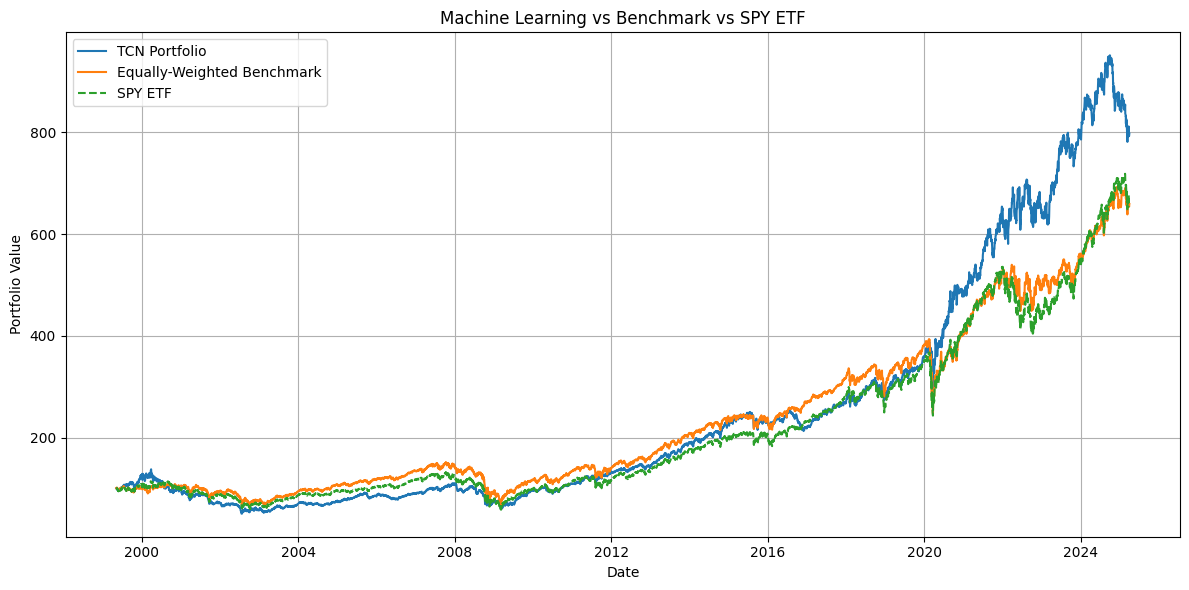


✅ Backtest complete.
Max log return: 0.1525034416184086
Min log return: -0.2249097392625117


In [65]:
plt.figure(figsize=(12, 6))
plt.plot(performance.index, performance['portfolio_value'], label='TCN Portfolio')
plt.plot(performance.index, performance['benchmark_value'], label='Equally-Weighted Benchmark')
plt.plot(spy.index, spy['value'], label='SPY ETF', linestyle='--')
plt.title("Machine Learning vs Benchmark vs SPY ETF")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n✅ Backtest complete.")
print("Max log return:", returns.max().max())
print("Min log return:", returns.min().min())


# 9) PLOTTING AN EXAMPLE OF AN ACTUAL VS PREDICTED COVARIANCE MATRIX

Index 575: MAE × 10 000 = 0.93
Index 1140: MAE × 10 000 = 0.39
Index 2340: MAE × 10 000 = 0.90
Index 6100: MAE × 10 000 = 0.23


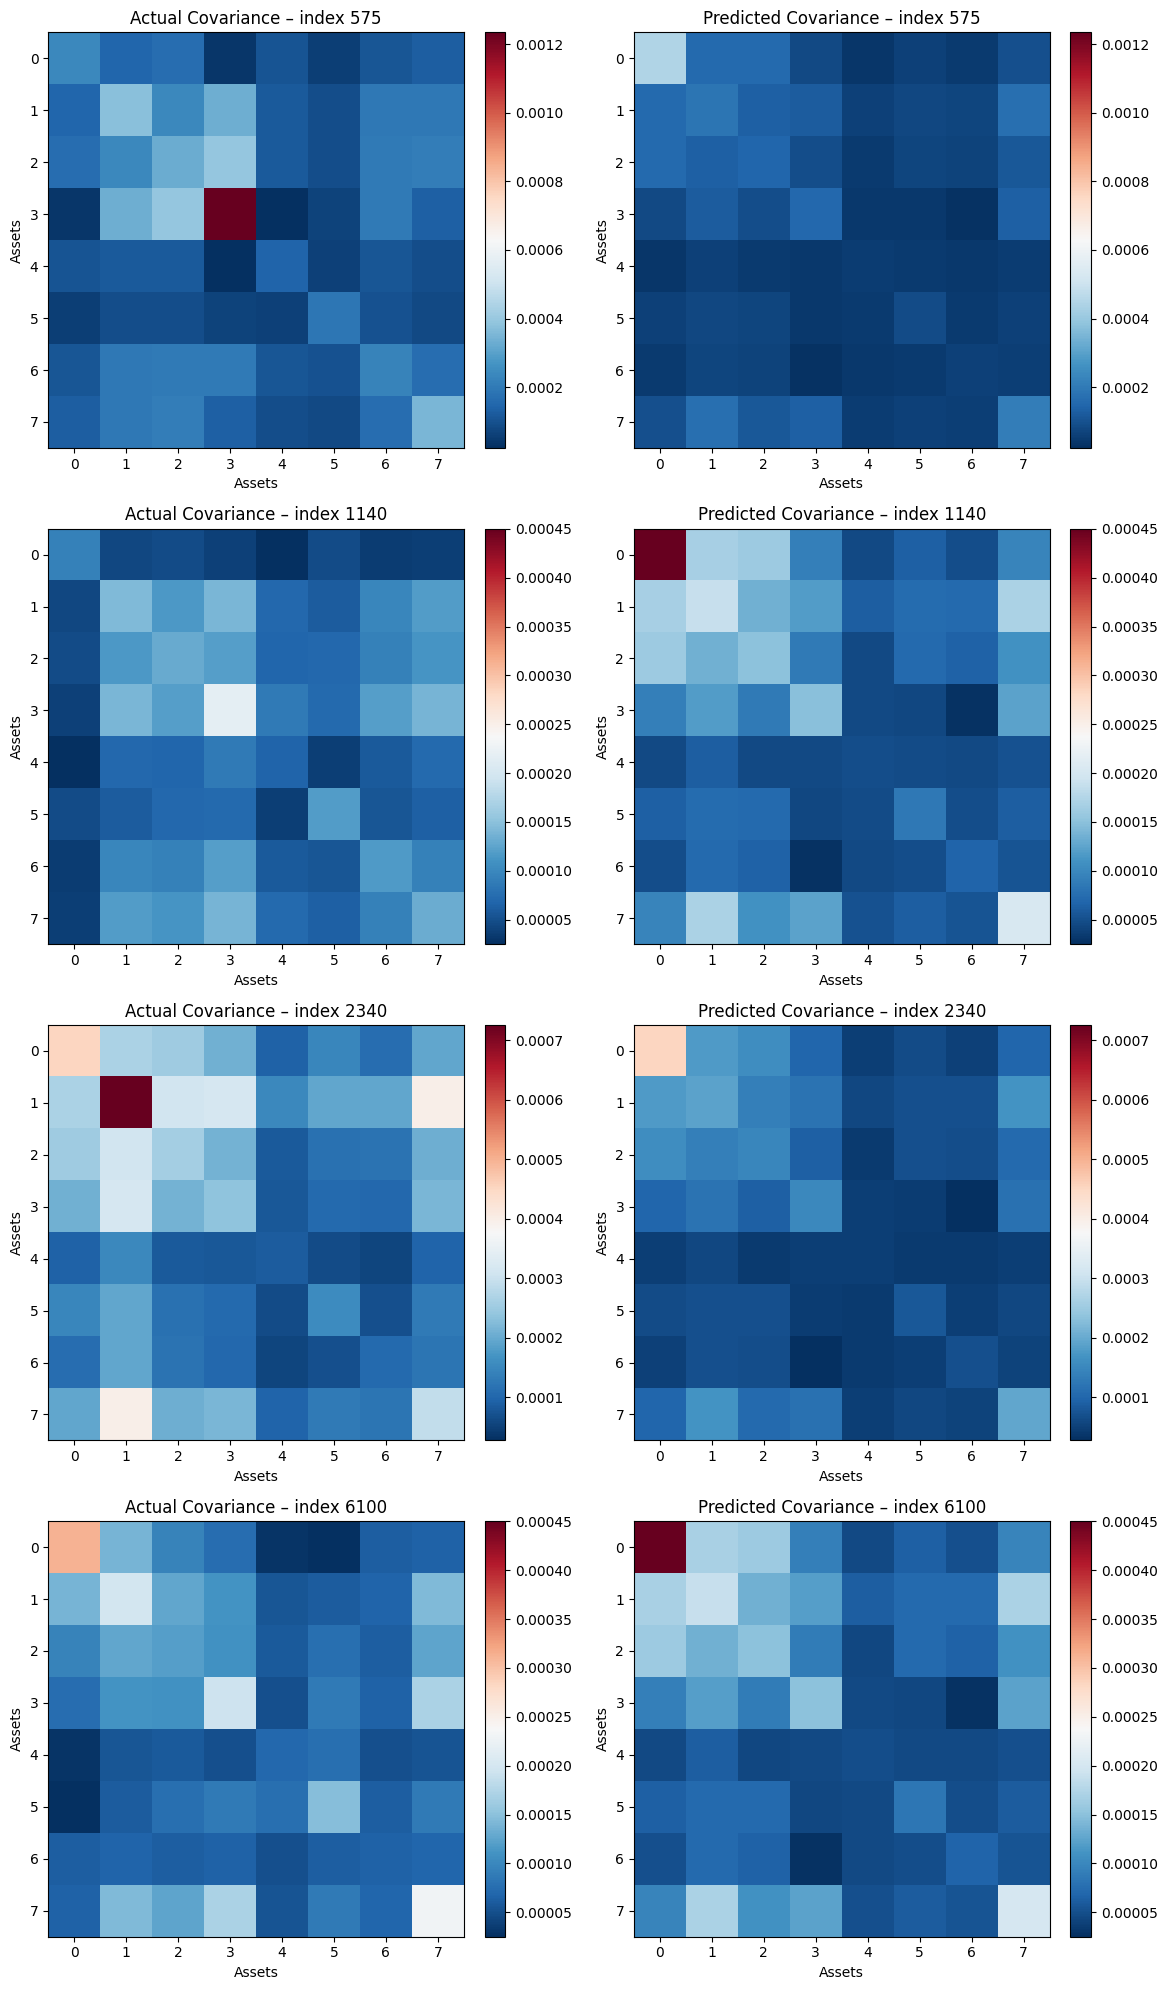

In [66]:
# --- scegli i quattro indici temporali ---
i, j, k, t = 575, 1140, 2340, 6100      # <-- modifica qui se vuoi
indices = [i, j, k, t]

cmap_choice = "RdBu_r"
fig, axes = plt.subplots(len(indices), 2, figsize=(12, 5 * len(indices)))

for row, idx in enumerate(indices):
    # 1) Covarianza reale (ultimi 63 giorni)
    window = returns.iloc[idx - 63 : idx]
    actual_cov = window.cov().values

    # 2) Covarianza predetta dal TCN
    predicted_cov = predict_next_day_cov(model_cov, idx, returns, sequence_length)

    # 3) stessa scala colori per entrambe
    vmin = min(actual_cov.min(), predicted_cov.min())
    vmax = max(actual_cov.max(), predicted_cov.max())

    # --- plot ACTUAL ---
    im0 = axes[row, 0].imshow(actual_cov, cmap=cmap_choice, vmin=vmin, vmax=vmax)
    axes[row, 0].set_title(f"Actual Covariance – index {idx}")
    axes[row, 0].set_xlabel("Assets"); axes[row, 0].set_ylabel("Assets")
    fig.colorbar(im0, ax=axes[row, 0], fraction=0.046, pad=0.04)

    # --- plot PREDICTED ---
    im1 = axes[row, 1].imshow(predicted_cov, cmap=cmap_choice, vmin=vmin, vmax=vmax)
    axes[row, 1].set_title(f"Predicted Covariance – index {idx}")
    axes[row, 1].set_xlabel("Assets"); axes[row, 1].set_ylabel("Assets")
    fig.colorbar(im1, ax=axes[row, 1], fraction=0.046, pad=0.04)

    # 4) MAE × 10 000
    mae = np.mean(np.abs(actual_cov - predicted_cov)) * 10000
    print(f"Index {idx}: MAE × 10 000 = {mae:.2f}")

plt.tight_layout()
plt.show()


# 10) Testing in the Future
The model trained on data up to 31/03/2025, is being tested on live data

✅ Log returns loaded. Shape: (348, 8)
📁 Weights history saved in weights_history.csv
📁 Saved performance results to tangent_vs_benchmark_performance_live.csv

📊 Performance Metrics:
🔵 TCN Portfolio
  • Sharpe Ratio: -0.86
  • Volatility annualized: 4.77%
  • Max Drawdown: -7.93%

🟧 Equally-Weighted Benchmark
  • Sharpe Ratio: 0.10
  • Volatility annualized: 6.55%
  • Max Drawdown: -11.76%

🟩 SPY ETF
  • Sharpe Ratio: 0.48
  • Volatility: 8.21%
  • Max Drawdown: -12.05%



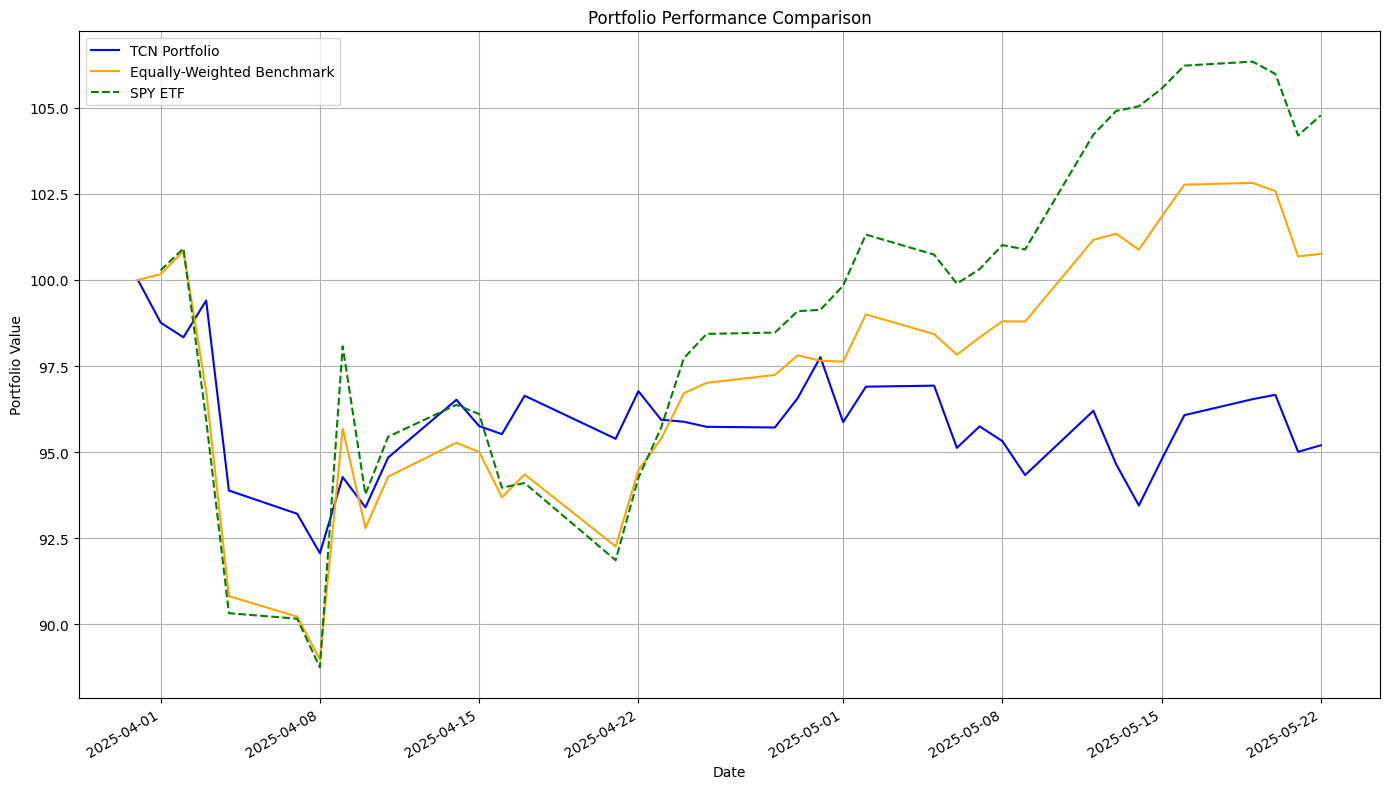

In [67]:
# CALCULATE MU HISTORICAL
returns_path = r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\etf_returns_v4.csv"


returns = pd.read_csv(returns_path, index_col=0, parse_dates=True)
etf_columns = returns.columns.tolist()
returns.replace([np.inf, -np.inf], np.nan, inplace=True)
returns.dropna(inplace=True)

mu_historical = returns.mean().values

# Parameters
sequence_length = 63
window_size = 21
start_index = window_size + sequence_length
start_date = '2025-03-31'

# transaction cost per unit turnover 
transaction_cost = 0.05 / 100  # 0.00195 is a reasonable cost for a retail investor, 0.0005 for institutionals
slippage = 0.025 / 100
c = transaction_cost + slippage
# risk aversion
gamma = 3.5 #
# box constraints
lb, ub = -0.33, 0.66 

shrink_alpha = 0.025

tickers = ['XLF', 'XLK', 'XLE', 'XLU', 'XLI', 'XLV', 'XLY', 'XLP']

# Data Download
data = yf.download(
    tickers,
    start='2024-01-01',
    interval='1d',
    auto_adjust=True,
    progress=False
)['Close']

returns = np.log(data / data.shift(1)).dropna()
etf_columns = returns.columns.tolist()
print("✅ Log returns loaded. Shape:", returns.shape)

# FUNCTIONS

def predict_next_day_cov(model_cov, i, returns_df, seq_len): #seq_len=63
    """
    Predict next-day covariance factor from the last 'seq_len' Cholesky matrices,
    which are built from rolling 63-day windows each.
    """
    cov_input = []
    for j in range(i - seq_len, i):
        window = returns_df.iloc[j - seq_len : j] # j -63
        cov = window.cov().values
        L = np.linalg.cholesky(cov + np.eye(cov.shape[0]) * 1e-8)
        cov_input.append(torch.tensor(L, dtype=torch.float32))

    x_cov = torch.stack(cov_input).unsqueeze(0)  # shape (1, seq_len, n_assets, n_assets)
    with torch.no_grad():
        L_pred = model_cov(x_cov)
        cov_pred = torch.bmm(L_pred, L_pred.transpose(1, 2)).squeeze(0).numpy()
    cov_pred += np.eye(cov_pred.shape[0]) * 1e-8  # Stabilizer, default 1e-7, faster calculations, more stability and better overall results but less realistic
    return cov_pred

def predict_next_day_global(i, returns_df, cov_length=180):
    """
    Use global mean + momentum EWMAs for mu, and predict cov via TCN.
    """
    ewma_span_1 = 30
    ewma_span_2 = 90
    ewma_span_3 = 180

    ewma_1 = returns.iloc[i - sequence_length : i].ewm(span=ewma_span_1, adjust=False).mean()
    mu_short_1 = ewma_1.iloc[-1].values

    ewma_2 = returns.iloc[i - sequence_length : i].ewm(span=ewma_span_2, adjust=False).mean()
    mu_short_2 = ewma_2.iloc[-1].values

    ewma_3 = returns.iloc[i - sequence_length : i].ewm(span=ewma_span_3, adjust=False).mean()
    mu_short_3 = ewma_3.iloc[-1].values

    mu_pred = mu_historical * (1 - 3 * shrink_alpha) + shrink_alpha * (mu_short_1 + mu_short_2 + mu_short_3)

    cov_pred = predict_next_day_cov(model_cov, i, returns_df, seq_len=cov_length)
    return mu_pred, cov_pred


def turnover_penalized_weights(mu, cov, w_prev, gamma, turnover_cost, lb, ub):
    
    alpha = 0.35 # mix L1/L2: 1=L1 puro, 0=L2 puro
    
    n = len(mu)
    w = cp.Variable(n)

    cost_turn = alpha * cp.norm1(w - w_prev) + (1-alpha) * cp.sum_squares(w - w_prev)

    obj = cp.Maximize(
        mu @ w
        - (gamma/2)*cp.quad_form(w, cov)
        - 0.8 * turnover_cost * cost_turn
    )
    constraints = [
        cp.sum(w) == 1,
        w >= lb,
        w <= ub
    ]
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    return w.value 
    

# Main Loop
portfolio_values = []
benchmark_returns = []
portfolio_returns = []
dates = []
weights_list = []
w_prev = equal_weights  # inizializzazione per il primo giorno

portfolio_value = None
equal_weights = np.repeat(1 / len(etf_columns), len(etf_columns))

first_trade_done = False

for i in range(start_index, len(returns) - 1):
    mu_pred, cov_pred = predict_next_day_global(i, returns, cov_length=sequence_length)

    # ⚠️ penalità 0 SOLO nel primo trade
    turnover_cost_eff = 0.0 if not first_trade_done else c
    
    weights = turnover_penalized_weights(
        np.asarray(mu_pred), cov_pred,
        np.asarray(w_prev),
        gamma,
        turnover_cost_eff,
        lb, ub
    )


    real_ret = returns.iloc[i + 1].values

    turnover = np.sum(np.abs(weights - w_prev))

    # ✅ Salta l'operazione se il turnover è sotto la soglia
    if turnover < 0.01:
        weights = w_prev  # non cambiare i pesi
        turnover = 0.0
        cost = 0.0
        portfolio_log_ret = weights @ real_ret
    else:
        cost = c * turnover
        portfolio_log_ret = weights @ (real_ret - np.log(1 - cost))
    
    w_prev = weights

    
    log_ret_bench = equal_weights @ real_ret
    date = returns.index[i + 1]

    if date == pd.to_datetime(start_date):
        portfolio_value = 100.0
        portfolio_values.append(portfolio_value)
        benchmark_returns.append(0)
        portfolio_returns.append(0)
        dates.append(date)
        weights_list.append(equal_weights)
        continue

    if portfolio_value is not None:
        first_trade_done = True
        portfolio_value *= np.exp(portfolio_log_ret)
        portfolio_returns.append(portfolio_log_ret)
        benchmark_returns.append(log_ret_bench)       # ← deve essere log_ret_bench
        portfolio_values.append(portfolio_value)
        dates.append(date)
        weights_list.append(weights)


# Saving the Results
weights_df = pd.DataFrame(weights_list, columns=etf_columns, index=dates)
weights_df.index.name = "date"
weights_df.to_csv(
    r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\weights_history_live.csv"
)
print("📁 Weights history saved in weights_history.csv")

benchmark_values = 100 * np.exp(np.cumsum(benchmark_returns))

performance = pd.DataFrame({
    'date': dates,
    'portfolio_value': portfolio_values,
    'benchmark_value': benchmark_values,
    'portfolio_return': portfolio_returns
}).set_index('date')

performance = performance[performance.index >= pd.to_datetime(start_date)]
performance.to_csv(
    r"C:\Users\alpor\OneDrive\Desktop\politecnico\CORSI ERASMUS\MACHINE LEARNING\PROGETTO\tcn-portfolio v4\DATA\tangent_vs_benchmark_performance_live.csv"
)
print("📁 Saved performance results to tangent_vs_benchmark_performance_live.csv")

# SPY Comparison
if not performance.empty:
    spy = yf.download(
    "SPY",
    start=(performance.index[0] - pd.Timedelta(days=1)).strftime('%Y-%m-%d'),  # per avere un punto precedente per log-ret
    end=(performance.index[-1] + pd.Timedelta(days=1)).strftime('%Y-%m-%d'),   # include anche l’ultimo giorno
    progress=False
)["Close"]

    spy = spy.ffill()
    spy = spy.loc[performance.index[0] - pd.Timedelta(days=1): performance.index[-1]]
    spy_returns = np.log(spy / spy.shift(1)).dropna()
    spy_value = 100 * np.exp(spy_returns.cumsum()).reindex(performance.index).ffill()
    performance["spy_value"] = spy_value


    def compute_metrics(values):
        log_ret = np.log(values / values.shift(1)).dropna()
        n = len(log_ret)
        multiplier = np.sqrt(365 / n)
        sharpe = 365 * log_ret.mean() / (log_ret.std() * n) if log_ret.std() != 0 else np.nan
        vol = log_ret.std() * multiplier
        drawdown = (values / values.cummax() - 1).min()
        return sharpe, vol, drawdown

    sharpe_tcn, vol_tcn, dd_tcn = compute_metrics(performance["portfolio_value"])
    sharpe_eqw, vol_eqw, dd_eqw = compute_metrics(performance["benchmark_value"])
    sharpe_spy, vol_spy, dd_spy = compute_metrics(performance["spy_value"])

    print("""
📊 Performance Metrics:
🔵 TCN Portfolio
  • Sharpe Ratio: {:.2f}
  • Volatility annualized: {:.2%}
  • Max Drawdown: {:.2%}

🟧 Equally-Weighted Benchmark
  • Sharpe Ratio: {:.2f}
  • Volatility annualized: {:.2%}
  • Max Drawdown: {:.2%}

🟩 SPY ETF
  • Sharpe Ratio: {:.2f}
  • Volatility: {:.2%}
  • Max Drawdown: {:.2%}
""".format(
        sharpe_tcn, vol_tcn, dd_tcn,
        sharpe_eqw, vol_eqw, dd_eqw,
        sharpe_spy, vol_spy, dd_spy
    ))
    # Convert it to a pure index (remove hours)
    
    performance.index = pd.to_datetime(performance.index).normalize()
    plt.figure(figsize=(14, 8))
    plt.plot(performance.index, performance["portfolio_value"], label="TCN Portfolio", color="blue")
    plt.plot(performance.index, performance["benchmark_value"], label="Equally-Weighted Benchmark", color="orange")
    plt.plot(performance.index, performance["spy_value"], label="SPY ETF", color="green", linestyle="dashed")
    
    plt.title("Portfolio Performance Comparison")
    plt.ylabel("Portfolio Value")
    plt.xlabel("Date")
    
    # Remove hours and set only yyyy-mm-dd
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ DataFrame performance is empty, no data to plot or comparison with SPY.")